In [1]:
# Imports
import math
from typing import Callable, Set, List  # for type hints, not required for execution

In [2]:
class Node:
    def __init__(self, out: float, _prev: tuple = ()):
        self.out = float(out) # numeric forward value
        self.delta = 0.0 # accumulated derivative of final loss w.r.t this node
        self._prev = set(_prev) # set of input nodes used to compute this node (for topology build)
        self._backward: Callable[[], None] = lambda: None # local function that, when called, distributes this node's delta to its inputs
        self.label = ""
        self._id = id(self)
    def __repr__(self):
        return f"Node(out={self.out:.6f}, delta={self.delta:.6f})"
    def __hash__(self):
        return self._id
    def __add__(self, other):
        other = other if isinstance(other, Node) else Node(float(other))
        out = Node(self.out + other.out, (self, other))
        def _backward():
            # d(a+b)/da = 1 ; d(a+b)/db = 1
            self.delta += 1.0 * out.delta
            other.delta += 1.0 * out.delta
        out._backward = _backward
        return out
    def __radd__(self, other):
        return self + other
    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(float(other))
        out = Node(self.out * other.out, (self, other))
        def _backward():
            # d(a*b)/da = b ; d(a*b)/db = a
            self.delta += other.out * out.delta
            other.delta += self.out * out.delta
        out._backward = _backward
        return out
    def __rmul__(self, other):
        return self * other
    def __neg__(self):
        out = Node(-self.out, (self,))
        def _backward():
            self.delta += -1.0 * out.delta
        out._backward = _backward
        return out
    def __sub__(self, other):
        other = other if isinstance(other, Node) else Node(float(other))
        return self + (-other)
    def __rsub__(self, other):
        other = other if isinstance(other, Node) else Node(float(other))
        return other - self
    def __pow__(self, exponent: int):
        out = Node(self.out ** exponent, (self,))
        def _backward():
            if exponent != 0:
                self.delta += exponent * (self.out ** (exponent - 1)) * out.delta
        out._backward = _backward
        return out


In [3]:
# activation functions and backprop utilities
def sigmoid(node: Node, lam: float = 1.0) -> Node:
    s = 1.0 / (1.0 + math.exp(-lam * node.out))
    out = Node(s, (node,))
    def _backward():
        # d/dn sigmoid(lam*n) = lam * s * (1 - s)
        node.delta += lam * (out.out * (1.0 - out.out)) * out.delta
    out._backward = _backward
    return out

def tanh_node(node: Node) -> Node:
    t = math.tanh(node.out)
    out = Node(t, (node,))
    def _backward():
        node.delta += (1.0 - out.out * out.out) * out.delta
    out._backward = _backward
    return out

def build_topo(root: Node) -> List[Node]: # Topology build
    visited: Set[Node] = set()
    topo: List[Node] = []
    def dfs(v: Node):
        if v in visited:
            return
        visited.add(v)
        for p in v._prev:
            dfs(p)
        topo.append(v)
    dfs(root)
    return topo

def backward(root: Node):
    # seed the backward pass: ∂L/∂L = 1
    root.delta = 1.0
    topo = build_topo(root)
    for node in reversed(topo):
        node._backward()

In [4]:
# example usage, forward, backward, parameter update (gradient descent)
if __name__ == "__main__":
    x1 = Node(2.0); x1.label = "x1"
    x2 = Node(-1.0); x2.label = "x2"
    w1 = Node(3.0); w1.label = "w1"
    w2 = Node(0.5); w2.label = "w2"
    b  = Node(0.1); b.label  = "b"
    lam = 1.0
    n = x1 * w1 + x2 * w2 + b
    n.label = "n"
    O = sigmoid(n, lam=lam)
    O.label = "O"
    T = Node(0.5); T.label = "T"
    diff = T - O
    loss = 0.5 * (diff * diff)
    loss.label = "L"
    backward(loss)
    for node in [loss, O, n, w1, w2, b, x1, x2]:
        print(node.label.ljust(4), "out =", f"{node.out:.6f}", " delta =", f"{node.delta:.10f}")
    eta = 0.01
    for param in (w1, w2, b):
        param.out = param.out - eta * param.delta
    n2 = x1 * w1 + x2 * w2 + b
    O2 = sigmoid(n2, lam=lam)
    diff2 = T - O2
    loss2 = 0.5 * (diff2 * diff2)
    print("loss before:", f"{loss.out:.10f}", "loss after one update:", f"{loss2.out:.10f}")

L    out = 0.123165  delta = 1.0000000000
O    out = 0.996316  delta = 0.4963157601
n    out = 5.600000  delta = 0.0018218095
w1   out = 3.000000  delta = 0.0036436190
w2   out = 0.500000  delta = -0.0018218095
b    out = 0.100000  delta = 0.0018218095
x1   out = 2.000000  delta = 0.0054654286
x2   out = -1.000000  delta = 0.0009109048
loss before: 0.1231646669 loss after one update: 0.1231644677


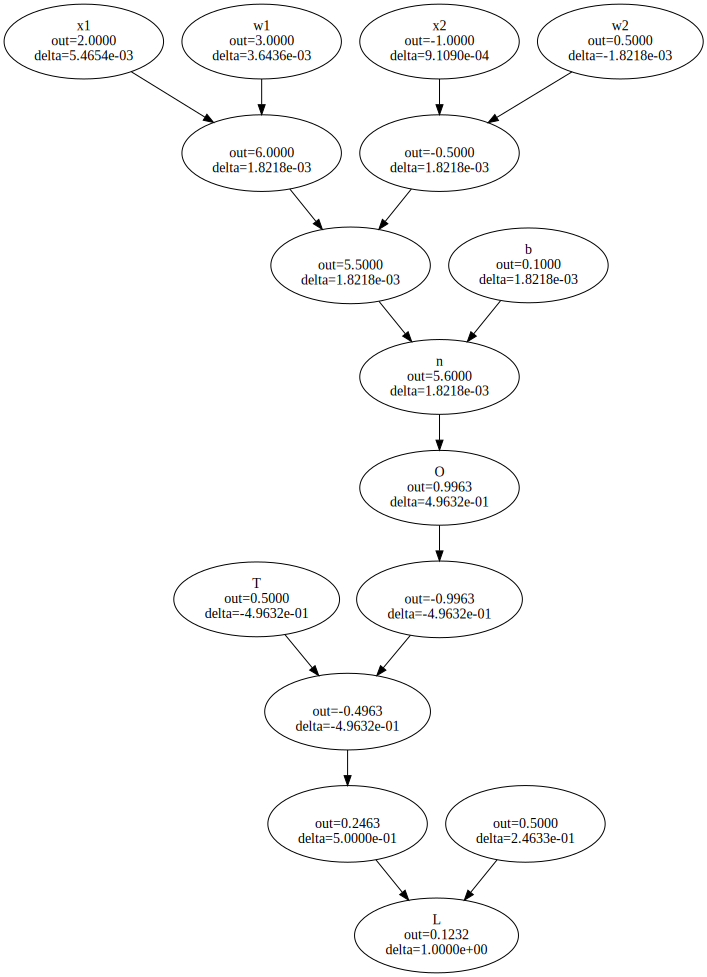

In [6]:
# Graphviz visualization block 
from graphviz import Digraph, Source

def show_graph(root: Node):
    topo = build_topo(root)
    dot = Digraph(comment="Computation Graph")

    # create nodes with labels
    for node in topo:
        label = f"{node.label}\\nout={node.out:.4f}\\ndelta={node.delta:.4e}"
        dot.node(str(id(node)), label=label)

    # create edges parent → child
    for node in topo:
        for p in node._prev:
            dot.edge(str(id(p)), str(id(node)))

    return Source(dot.source)

# call
show_graph(loss)